In [2]:
import os
# Set the environment variable
os.environ['STPSF_PATH'] = os.path.abspath("/home/yuchialin/JWST/stpsf_data")
#os.environ['WEBBPSF_EXT_PATH'] = os.path.abspath("stpsf_data")
#os.environ['PYSYN_CDBS'] = os.path.abspath("webbpsf_ext_data/cdbs")
#os.environ['CRDS_PATH'] = os.path.abspath("crds_cache")
#os.environ['CRDS_SERVER_URL'] = "https://jwst-crds.stsci.edu"

# Verify the variable is set
print("STPSF_PATH:", os.environ['STPSF_PATH'])
print("WEBBPSF_EXT_PATH:", os.environ['WEBBPSF_EXT_PATH'])
print("PYSYN_CDBS:", os.environ['PYSYN_CDBS'])
print("CRDS_PATH:", os.environ['CRDS_PATH'])

STPSF_PATH: /home/yuchialin/JWST/stpsf_data
WEBBPSF_EXT_PATH: /home/yuchialin/JWST/stpsf_data
PYSYN_CDBS: /home/yuchialin/JWST/webbpsf_ext_data/cdbs
CRDS_PATH: /home/yuchialin/JWST/crds_cache


In [3]:
# Imports
from IPython.display import display, HTML

def setup_display(width=95, fontsize=16):
    """
    Sets window width and markdown fontsize for Jupyter notebook. Width is % of window.
    """
    display(HTML("<style>.container { width:"+str(width)+"% !important; }</style>"))
    display(HTML("<style>.rendered_html { font-size: "+str(fontsize)+"px; }</style>"))
    return None

def source(fn):
    import inspect
    print(inspect.getsource(fn))
    return None

import numpy as np
import glob
import winnie
from winnie.plot import animate_quick_implot, quick_implot, mpl, plt
from spaceKLIP import database
import webbpsf
import astropy.units as u

plt.style.use('winnie.winnie_mplstyle') # Comment this out or replace it if you prefer a different plot style

setup_display()

In [4]:
# Prep the SpaceRDI object:
distance = 60.1 # Distance to your target in parsecs

base_dir = 'data_twhya_winnie/'
input_dir = f'{base_dir}padded/'
data_ext = 'calints'
fitsfiles = np.sort(glob.glob(f'{input_dir}*{data_ext}.fits')) # Populate a file list

In [5]:
# Initialize the spaceKLIP database
Database = database.Database(base_dir)
Database.verbose = False
Database.read_jwst_s012_data(datapaths=fitsfiles)

# Create the SpaceRDI object we'll use to carry out RDI
wdb = winnie.SpaceRDI(Database, output_subdir='WinnieRDI', overwrite=True, verbose=True, pad_data='auto')

In [6]:
# Task 3: Add artifact and apply ref_mask
wdb.load_concat(0)
bad_ind = 3
fake_artifact = np.where(winnie.utils.dist_to_pt([123,248], wdb.nx, wdb.ny) < 2.5, 5.0, 0.0)
wdb.imcube_ref[bad_ind] += fake_artifact

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (650,650)
Reference data: 37 exposures of shape (650,650)

RDI Settings:
Mode: RDI (Winnie)
Extension for output files: 'rdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [7]:
# Create reference mask (Key Task3 integration)
ref_mask = np.ones((wdb.optzones.shape[0], wdb.imcube_ref.shape[0]), dtype=bool)
ref_mask[:, bad_ind] = False
wdb.set_fixed_rdi_settings(ref_mask=ref_mask)

In [8]:
# Task5: Prepare PSF convolution grid 
spec_synphot = webbpsf.specFromSpectralType('M0V', catalog='ck04')  # From Task2
try:
    wdb.prepare_convolution(spec_synphot, fov_pixels=201, osamp=2)
except Exception as e:
    print(f"PSF prep failed: {e}")
    wdb.prepare_convolution(None, fov_pixels=201, osamp=2)  # Fallback

Setting up sim to match data_twhya_winnie/padded/jw01179005001_03106_00001_nrcalong_calints.fits

MAST OPD query around UTC: 2024-02-14T09:52:09.894
                        MJD: 60354.411225625

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/O2024021301-NRCA3_FP1-1.fits
	Date (MJD):	 60353.2554
	Delta time:	 -1.1559 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/O2024021601-NRCA3_FP1-1.fits
	Date (MJD):	 60355.7958
	Delta time:	 1.3846 days
User requested choosing OPD time closest in time to 2024-02-14T09:52:09.894, which is O2024021301-NRCA3_FP1-1.fits, delta time -1.156 days
Importing and format-converting OPD from /home/yuchialin/JWST/stpsf_data/MAST_JWST_WSS_OPDs/O2024021301-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point (NRCA3_FP1)

Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F356W
    Detector: NRCA5
    Apername: NRCA5_MASK335R
    Det. Pos.: (150, 174) 

In [9]:
# Run HPFRDI with ref_mask (Task3's contribution)
wdb.hpfrdi_presets()
hpfrdi_reduc = wdb.run_rdi() 

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (650,650)
Reference data: 37 exposures of shape (650,650)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x7746fc6694e0>
'opt_smoothing_kwargs': {'filtersize': 0.969667093183099}
'ref_mask': <class 'numpy.ndarray'> of shape (1, 37)
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


In [10]:
# Enhanced deconvolution setup (From Task5)
reduc_in = None # for None, run_deconvolution will run a simple HPFRDI reduction and use that for deconvolution
num_iter = 200
return_iters = np.concatenate([np.arange(1,10), np.arange(10,num_iter+1,10)])
excl_mask = winnie.utils.px_size_to_ang_size(
    winnie.utils.dist_to_pt(wdb.c_star, wdb.nx, wdb.ny),
    wdb.pxscale
).value > 7

# Run deconvolution on HPFRDI with artifact mitigation (Combined core)
deconv_reduc = wdb.run_deconvolution(reduc_in, num_iter=num_iter, auto_eps_errtol=0.05, 
                            return_iters=return_iters, save_products=True,
                            show_progress=True, excl_mask_in=excl_mask,
                            init_from_reduc=True)

JWST_NIRCAM_NRCALONG_F356W_MASKRND_MASK335R_SUB320A335R
Science data:   2 exposures of shape (650,650)
Reference data: 37 exposures of shape (650,650)

RDI Settings:
Mode: HPFRDI (Winnie)
'opt_smoothing_fn': <function high_pass_filter_sequence at 0x7746fc6694e0>
'opt_smoothing_kwargs': {'filtersize': 0.969667093183099}
'ref_mask': <class 'numpy.ndarray'> of shape (1, 37)
Extension for output files: 'hpfrdi_psfsub'
1 optimization zone(s)
1 subtraction zone(s)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
info_str = "Unknown Filter/Wavelength"
pixel_scale_value = None
units = "arcsec"
try:
    # ... (load concat if needed) ...
    current_concat_key = wdb.concat
    # ... (get key string if needed) ...
    filter_name = wdb.database.obs[current_concat_key]['FILTER'][0]
    wavelength = wdb.database.obs[current_concat_key]['CWAVEL'][0]
    info_str = f"{filter_name} ({wavelength:.2f} µm)"

    # Get pixel scale
    pixel_scale_value = wdb.pxscale.to(u.arcsec/u.pixel).value

except NameError:
    print("Warning: 'wdb' object not found. Cannot add scale bar or filter info.")
except AttributeError:
     print("Warning: Could not find 'pxscale' attribute on 'wdb'. Cannot add scale bar.")
except Exception as e:
    print(f"Warning: Could not retrieve info dynamically ({e}). Scale bar or filter info might be missing.")

print(f"Pixel scale found: {pixel_scale_value} {units}/pixel")
print(f"Filter info: {info_str}")

Pixel scale found: 0.062424185 arcsec/pixel
Filter info: F356W (3.59 µm)


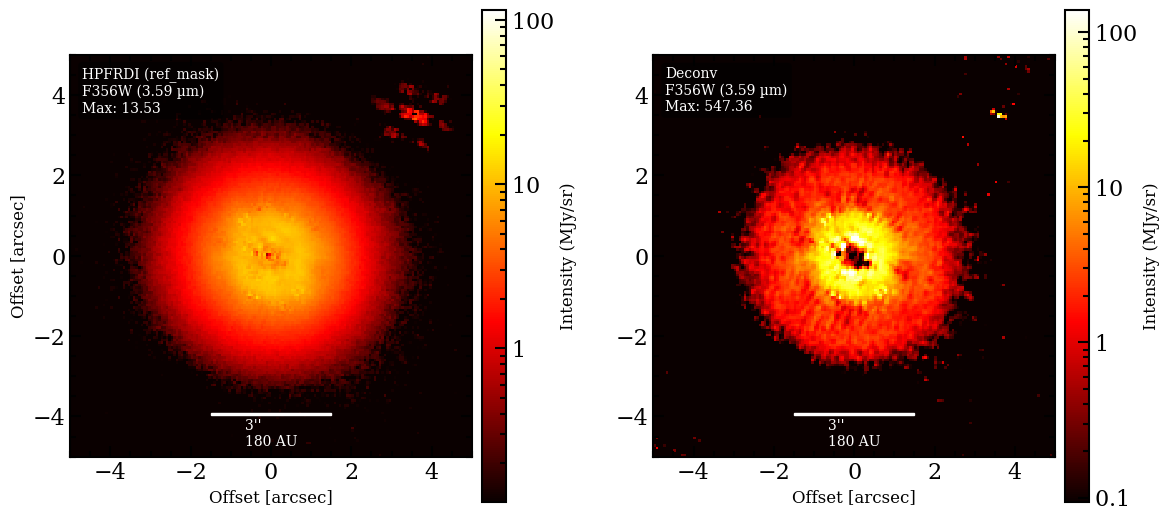

In [13]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # Import for scale bar
import matplotlib.font_manager as fm # Font properties for scale bar (optional)

images_to_plot = [deconv_reduc[1].im, deconv_reduc[0].im] # Use the deconvolved image and HPFRDI image
labels = ['HPFRDI (ref_mask)', 'Deconv']
# Create figure and axes for two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5.5)) # Adjusted figsize for colorbars
fontprops = fm.FontProperties(size=10) # Font properties for scale bar label
# Loop through each image/axis to plot individually
for i, ax in enumerate(axes):
    img_data = images_to_plot[i]

    # Calculate color limits for this specific image using the requested formula
    if i == 0:
        clim_low_raw, clim_high_raw = np.array([0.01, 10.0]) * np.nanpercentile(img_data, 99.975)
    else:
        clim_low_raw, clim_high_raw = np.array([0.001, 1.5]) * np.nanpercentile(img_data, 99.975)

    # Create LogNorm object, handling potential non-positive values robustly
    try:
        # Find minimum positive value if needed
        min_positive = np.nanmin(img_data[img_data > 0]) if np.any(img_data > 0) else None
        # Set vmin safely
        vmin_safe = max(clim_low_raw, min_positive) if min_positive is not None and clim_low_raw <= min_positive else clim_low_raw
        if vmin_safe <= 0:
             vmin_safe = 1e-9 # Default tiny positive if calculation failed
             print(f"Warning: Setting vmin to {vmin_safe:.1e} for LogNorm in plot {i} ({labels[i]})")

        # Set vmax safely
        vmax_safe = max(clim_high_raw, vmin_safe * 1.1) # Ensure vmax > vmin
        if vmax_safe <= vmin_safe:
             vmax_safe = vmin_safe * 10
             print(f"Warning: Adjusting vmax for LogNorm in plot {i} ({labels[i]})")

        norm = mpl.colors.LogNorm(vmin=vmin_safe, vmax=vmax_safe, clip=True) # Use clip=True
    except Exception as e:
        print(f"Error creating LogNorm for plot {i}, using linear scale instead: {e}")
        norm = None # Fallback to linear scale

    # --- Use ax.imshow ---
    im = ax.imshow(
        img_data,
        cmap='hot',
        norm=norm, # Apply the LogNorm object (or None for linear)
        extent=deconv_reduc[i].extent, # Use extent from the corresponding reduction object
        origin='lower', # Standard for astronomical images
        interpolation='nearest' # Often preferred over bilinear for data
    )

    # --- Add Colorbar for this specific axis ---
    cbar = fig.colorbar(im, ax=ax, pad=0.02) # Attach colorbar to figure, associated with ax
    cbar_unit = wdb.database.obs[wdb.concat]['BUNIT'][0]
    cbar.set_label('Intensity (%s)' % cbar_unit, fontsize=12)

    # --- Add Text Label (Original Logic) ---
    current_max_brightness = np.nanmax(img_data)
    text_label = f"{labels[i]}\n{info_str}\nMax: {current_max_brightness:.2f}"
    ax.text(0.03, 0.97, text_label,
            ha='left', va='top',
            transform=ax.transAxes,
            fontsize=10, color='white',
            bbox=dict(boxstyle='round,pad=0.3', fc='black', alpha=0.5, ec='none'))

    # --- Add Scale Bar (Original Logic) ---
    if pixel_scale_value is not None and 'distance' in locals() or 'distance' in globals():
        try:
            scalebar_length_arcsec = 3
            scalebar_length_au = scalebar_length_arcsec * distance # distance needs to be defined
            scalebar_label = f"{scalebar_length_arcsec}''\n{scalebar_length_au:.0f} AU"

            scalebar = AnchoredSizeBar(ax.transData,
                                       scalebar_length_arcsec,
                                       scalebar_label,
                                       'lower center',
                                       pad=0.5, color='white', frameon=False,
                                       size_vertical=scalebar_length_arcsec * 0.02, # Make thickness relative to length
                                       fontproperties=fontprops)
            ax.add_artist(scalebar)
        except Exception as e:
            print(f"Error adding scale bar to plot {i}: {e}")
            ax.text(0.97, 0.03, "Scalebar Error", ha='right', va='bottom',
                    transform=ax.transAxes, fontsize=8, color='red')

    else:
        missing_info = []
        if pixel_scale_value is None: missing_info.append("scale")
        if not ('distance' in locals() or 'distance' in globals()): missing_info.append("distance")
        ax.text(0.97, 0.03, f"Scale info missing ({', '.join(missing_info)})", ha='right', va='bottom',
                transform=ax.transAxes, fontsize=8, color='yellow')

    # Set axis limits based on extent or desired lims
    # extent is [left, right, bottom, top]
    ax.set_xlim(-5, 5) # Set limits based on your data
    ax.set_ylim(-5, 5) # Set limits based on your data
    # Or set fixed limits if preferred:
    # ax.set_xlim(-5, 5)
    # ax.set_ylim(-5, 5)

    # Optional: Set axis labels
    ax.set_xlabel('Offset [arcsec]', fontsize=12)
    if i == 0: # Label y-axis only for the first plot
        ax.set_ylabel('Offset [arcsec]', fontsize=12)
    ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio

# Adjust layout to prevent overlap and show the plot
plt.tight_layout(pad=1.0, h_pad=1.5, w_pad=1.5) # Added padding
plt.show()

Calculating radial profiles with bin size 3 px up to 325 px...
Converted radius to AU using scale 0.0624 arcsec/px and distance 60.1 pc.
Generating plot...


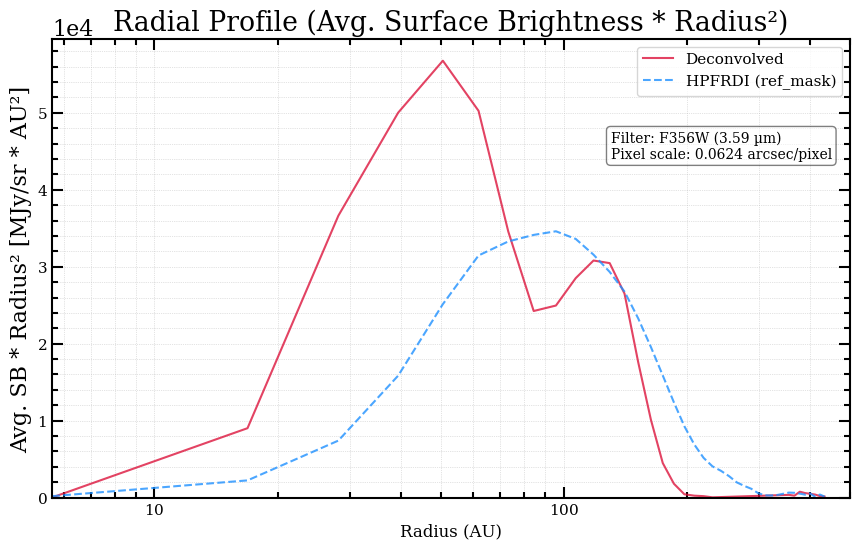

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

# Function to calculate radial profile using annular bins
def calculate_radial_profile(image_data, center_yx, max_radius_px, bin_size_px=1):
    """
    Calculates the average radial profile of an image in annular bins.

    Args:
        image_data (np.ndarray): The 2D image data.
        center_yx (tuple): The (y, x) coordinates of the center.
        max_radius_px (int): The maximum radius (in pixels) to calculate the profile up to.
        bin_size_px (int, optional): The width of each radial bin in pixels. Defaults to 1.

    Returns:
        tuple: (bin_centers_pixels, profile_values)
               - bin_centers_pixels (np.ndarray): The center radius of each bin in pixels.
               - profile_values (np.ndarray): The average value within each radial bin.
    """
    ny, nx = image_data.shape
    center_y, center_x = center_yx

    # Create coordinate grids
    y_coords, x_coords = np.ogrid[:ny, :nx]

    # Calculate squared distance from center for efficiency
    dist_sq = (x_coords - center_x)**2 + (y_coords - center_y)**2

    # Define radial bins
    radii_edges = np.arange(0, max_radius_px + bin_size_px, bin_size_px)
    profile_values = []

    # Calculate mean in each annulus
    for i in range(len(radii_edges) - 1):
        r_min_sq = radii_edges[i]**2
        r_max_sq = radii_edges[i+1]**2

        # Create mask for the current annulus
        mask_area = (dist_sq >= r_min_sq) & (dist_sq < r_max_sq)

        if np.any(mask_area): # Only calculate if mask is not empty
            avg_value = np.nanmean(image_data[mask_area])
        else:
            avg_value = np.nan # Handle empty bins

        profile_values.append(avg_value)

    # Use the center of the bins for the radius value
    bin_centers_pixels = radii_edges[:-1] + bin_size_px / 2.0
    return bin_centers_pixels, np.array(profile_values)


if __name__ == "__main__":
    # --- Input Data ---
    img_deconv = deconv_reduc[0].im
    img_hpfrdi = deconv_reduc[1].im
    labels = ['Deconvolved', 'HPFRDI (ref_mask)']
    colors = ['crimson', 'dodgerblue']
    linestyles = ['-', '--']

    # --- Determine Center and Max Radius ---
    # Assuming images are aligned and have the same shape
    if img_deconv.shape != img_hpfrdi.shape:
        print("Warning: Image shapes differ. Using shape of first image for geometry.")
    ny, nx = img_deconv.shape
    # Use integer division for center pixel index
    center_y, center_x = ny // 2, nx // 2
    # Calculate profile out towards the edge
    max_radius_px = min(ny, nx) // 2

    # --- Binning ---
    bin_size_px = 3 # Use 1-pixel wide bins for detailed profile

    # --- Calculate Profiles ---
    print(f"Calculating radial profiles with bin size {bin_size_px} px up to {max_radius_px} px...")
    radii_px_deconv, profile_deconv = calculate_radial_profile(img_deconv, (center_y, center_x), max_radius_px, bin_size_px)
    radii_px_hpfrdi, profile_hpfrdi = calculate_radial_profile(img_hpfrdi, (center_y, center_x), max_radius_px, bin_size_px)
    profiles = [profile_deconv, profile_hpfrdi]
    # Assuming radii are the same for both as images have same shape/center
    radii_px = radii_px_deconv

    # --- Unit Conversion ---
    x_label = 'Radius (pixels)' # Default label
    radii_plot = radii_px      # Default radii to plot
    try:
        if 'wdb' in locals() or 'wdb' in globals():
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            if 'distance' in locals() or 'distance' in globals():
                pixel_scale_au = pixel_scale_arcsec * distance
                radii_plot = radii_px * pixel_scale_au
                x_label = 'Radius (AU)'
                print(f"Converted radius to AU using scale {pixel_scale_arcsec:.4f} arcsec/px and distance {distance} pc.")
            else:
                 print("Warning: 'distance' variable not found. Cannot convert radius to AU.")
        else:
             print("Warning: 'wdb' object not found. Cannot get pixel scale to convert radius to AU.")
    except Exception as e:
        print(f"Warning: Error during unit conversion ({e}). Plotting radius in pixels.")
        radii_plot = radii_px
        x_label = 'Radius (pixels)'


    # --- Plotting ---
    print("Generating plot...")
    fig_radial, ax_radial = plt.subplots(figsize=(9, 6)) # Create a new figure

    for i in range(len(profiles)):
        # Filter out potential NaN values before plotting (especially for log scale)
        valid_mask = ~np.isnan(profiles[i]) & (profiles[i] > 0) # Also ensure positive for log scale
        if np.any(valid_mask):
             ax_radial.plot(radii_plot[valid_mask], profiles[i][valid_mask]*radii_plot[valid_mask]**2,
                           label=labels[i],
                           color=colors[i],
                           linestyle=linestyles[i],
                           markersize=4,
                           linewidth=1.5,
                           alpha=0.8)
        else:
             print(f"No valid data points found for profile: {labels[i]}")


    # --- Plot Styling ---
    ax_radial.set_xlabel(x_label, fontsize=12)
    # Clarify y-axis units if known, otherwise state they are image units
    y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
    ax_radial.set_ylabel(f'Avg. SB * Radius² [{y_units_str} * AU²]')
    ax_radial.set_title('Radial Profile (Avg. Surface Brightness * Radius²)')
    # Add a text box with filter info
    textstr = f"Filter: {info_str}\nPixel scale: {pixel_scale_value:.4f} {units}/pixel"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax_radial.text(0.7, 0.8, textstr, transform=ax_radial.transAxes,
                   fontsize=10, verticalalignment='top', bbox=props)

    # Set scales AFTER plotting data
    ax_radial.set_xscale('log') # Log scale for radius

    # Set x-axis and y-axis limits
    ax_radial.set_xlim(left=0, right=500) # Avoid zero radius
    ax_radial.set_ylim(bottom=0.0) # Avoid negative values

    # Scientific notation for y-axis
    ax_radial.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ax_radial.legend(fontsize=11)
    ax_radial.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7) # Add grid for readability
    ax_radial.tick_params(axis='both', which='major', labelsize=11) # Adjust tick label size

    # Optional: Set reasonable plot limits if auto-scaling is poor
    # Consider excluding the very first bin if it's often noisy or affected by centering
    if len(radii_plot) > 1:
         ax_radial.set_xlim(left=radii_plot[1 if bin_size_px==1 else 0]) # Start from second bin if bin_size is 1? Or adjust as needed.

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

Calculating radial profiles using 'log' bins...
Outlier clipping fraction: 5.0%
 -> Deconvolved: Log bins, num=100, min_r=1.0 px
 -> HPFRDI (ref_mask): Log bins, num=100, min_r=1.0 px
Converted radius to AU using scale 0.0624 arcsec/px and distance 60.1 pc.
Generating plot...


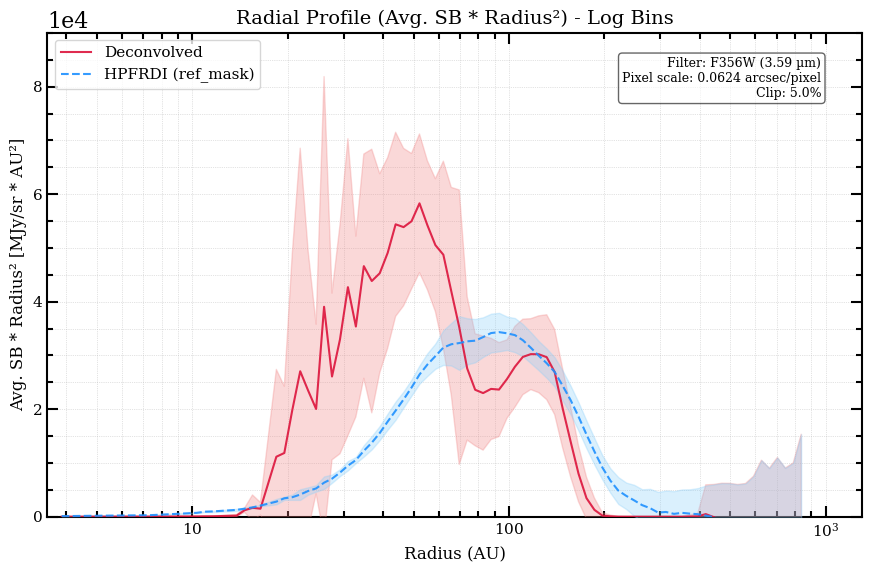

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import warnings # To handle potential warnings from nanpercentile etc.

# Function to calculate radial profile with options
def calculate_radial_profile(
    image_data,
    center_yx,
    max_radius_px,
    bin_type='linear', # 'linear' or 'log'
    bin_param=1, # bin_size_px if linear, num_bins if log
    min_radius_px=1.0, # Only used for log bins (must be > 0)
    outlier_clip_fraction=0.0 # Fraction of total data to clip (e.g., 0.05 clips top 2.5% and bottom 2.5%)
    ):
    """
    Calculates the average radial profile of an image in annular bins,
    with options for linear/log spacing, error calculation (std dev),
    and outlier rejection.

    Args:
        image_data (np.ndarray): The 2D image data.
        center_yx (tuple): The (y, x) coordinates of the center.
        max_radius_px (int): The maximum radius (in pixels) to calculate the profile up to.
        bin_type (str, optional): Type of radial bins: 'linear' or 'log'. Defaults to 'linear'.
        bin_param (int, optional): If bin_type='linear', this is the width of each bin (bin_size_px).
                                   If bin_type='log', this is the number of bins (num_bins).
                                   Defaults to 1 (meaning 1px linear bins).
        min_radius_px (float, optional): The minimum radius (in pixels) for the bins if bin_type='log'.
                                         Must be > 0. Defaults to 1.0.
        outlier_clip_fraction (float, optional): Total fraction of data points to clip from the
                                                 tails (lowest and highest values) within each bin
                                                 before calculating mean and std dev. E.g., 0.05 removes
                                                 the lowest 2.5% and highest 2.5%. Defaults to 0.0 (no clipping).

    Returns:
        tuple: (bin_centers_pixels, profile_mean, profile_std)
            - bin_centers_pixels (np.ndarray): The center radius of each bin in pixels.
            - profile_mean (np.ndarray): The (potentially clipped) average value within each radial bin.
            - profile_std (np.ndarray): The (potentially clipped) standard deviation within each radial bin.
            Returns (None, None, None) if inputs are invalid.
    """
    ny, nx = image_data.shape
    center_y, center_x = center_yx

    # --- Input Validation and Bin Setup ---
    if bin_type == 'log':
        if min_radius_px <= 0:
            print("Error: min_radius_px must be greater than 0 for log bins.")
            return None, None, None
        if max_radius_px <= min_radius_px:
            print("Error: max_radius_px must be greater than min_radius_px for log bins.")
            return None, None, None
        num_bins = int(bin_param)
        if num_bins <= 0:
            print("Error: Number of log bins (bin_param) must be > 0.")
            return None, None, None
        # We need num_bins + 1 edges to define num_bins intervals
        radii_edges = np.logspace(np.log10(min_radius_px), np.log10(max_radius_px), num_bins + 1)
        # Geometric mean for log bin centers
        bin_centers_pixels = np.sqrt(radii_edges[:-1] * radii_edges[1:])
    elif bin_type == 'linear':
        bin_size_px = int(bin_param)
        if bin_size_px <= 0:
            print("Error: Linear bin size (bin_param) must be > 0.")
            return None, None, None
        if max_radius_px <= 0:
            print("Error: max_radius_px must be > 0 for linear bins.")
            return None, None, None
        radii_edges = np.arange(0, max_radius_px + bin_size_px, bin_size_px)
        # Ensure max_radius is included if it falls exactly on an edge transition
        if radii_edges[-1] > max_radius_px + bin_size_px / 2: # Approx check
            radii_edges = radii_edges[:-1]
        if radii_edges[-1] < max_radius_px: # Ensure last edge reaches max_radius
            radii_edges = np.append(radii_edges, max_radius_px)

        # Arithmetic mean for linear bin centers
        bin_centers_pixels = radii_edges[:-1] + (radii_edges[1:] - radii_edges[:-1]) / 2.0
    else:
        print(f"Error: Unknown bin_type '{bin_type}'. Choose 'linear' or 'log'.")
        return None, None, None

    if outlier_clip_fraction < 0 or outlier_clip_fraction >= 1:
        print("Warning: outlier_clip_fraction should be between 0 and 1. Setting to 0.")
        outlier_clip_fraction = 0.0

    # --- Calculation ---
    y_coords, x_coords = np.ogrid[:ny, :nx]
    dist_sq = (x_coords - center_x)**2 + (y_coords - center_y)**2

    profile_mean_values = []
    profile_std_values = []

    for i in range(len(radii_edges) - 1):
        r_min_sq = radii_edges[i]**2
        r_max_sq = radii_edges[i+1]**2
        mask_area = (dist_sq >= r_min_sq) & (dist_sq < r_max_sq)

        avg_value = np.nan
        std_value = np.nan

        if np.any(mask_area):
            pixels_in_annulus = image_data[mask_area]
            # Filter out NaNs before potential clipping or calculation
            valid_pixels = pixels_in_annulus[np.isfinite(pixels_in_annulus)]

            if len(valid_pixels) > 0: # Proceed only if non-NaN pixels exist
                if outlier_clip_fraction > 0 and len(valid_pixels) > 2: # Need >2 points to clip meaningfully
                    lower_percentile = (outlier_clip_fraction / 2.0) * 100
                    upper_percentile = (1.0 - outlier_clip_fraction / 2.0) * 100
                    try:
                        # Use nanpercentile just in case, though we filtered finite values
                        with warnings.catch_warnings(): # Suppress warnings if percentile is outside data range
                            warnings.simplefilter("ignore", category=RuntimeWarning)
                            vmin, vmax = np.percentile(valid_pixels, [lower_percentile, upper_percentile])

                        # Clip the data
                        clipped_pixels = valid_pixels[(valid_pixels >= vmin) & (valid_pixels <= vmax)]

                        if len(clipped_pixels) > 0:
                            avg_value = np.mean(clipped_pixels)
                            # Need at least 2 points for meaningful std dev
                            std_value = np.std(clipped_pixels) if len(clipped_pixels) > 1 else 0.0
                        else:
                            # If clipping removed all data (unlikely but possible), revert to original mean/std
                            avg_value = np.mean(valid_pixels)
                            std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0

                    except IndexError: # Handles cases where percentile calculation fails (e.g., too few points)
                        # Fallback to no clipping if percentile fails
                        avg_value = np.mean(valid_pixels)
                        std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0
                else:
                    # No clipping requested or too few points
                    avg_value = np.mean(valid_pixels)
                    std_value = np.std(valid_pixels) if len(valid_pixels) > 1 else 0.0 # Std dev is 0 for 1 point

        profile_mean_values.append(avg_value)
        profile_std_values.append(std_value)

    return bin_centers_pixels, np.array(profile_mean_values), np.array(profile_std_values)


if __name__ == "__main__":
    # --- User Choices ---
    BINNING_MODE = 'log' # Options: 'linear' or 'log'
    OUTLIER_CLIP = 0.05   # Fraction to clip (e.g., 0.05 = 5% total), 0.0 to disable

    # --- Binning Parameters ---
    # Parameters for LINEAR binning
    linear_bin_size_px = 3
    # Parameters for LOG binning
    num_log_bins = 100
    min_radius_px_log = 1.0 # Smallest radius for log bins (must be > 0)

    # --- Input Data ---
    img_deconv = deconv_reduc[0].im
    img_hpfrdi = deconv_reduc[1].im
    labels = ['Deconvolved', 'HPFRDI (ref_mask)']
    colors = ['crimson', 'dodgerblue']
    linestyles = ['-', '--']
    fill_colors = ['lightcoral', 'lightskyblue'] # Colors for error bands

    # --- Determine Center and Max Radius ---
    if img_deconv.shape != img_hpfrdi.shape:
        print("Warning: Image shapes differ. Using shape of first image for geometry.")
    ny, nx = img_deconv.shape
    center_y, center_x = ny // 2, nx // 2
    max_radius_px = min(ny, nx) // 2

    # --- Calculate Profiles ---
    profiles_mean = []
    profiles_std = []
    radii_px_list = []

    print(f"Calculating radial profiles using '{BINNING_MODE}' bins...")
    print(f"Outlier clipping fraction: {OUTLIER_CLIP*100:.1f}%")

    for i, img in enumerate([img_deconv, img_hpfrdi]):
        if BINNING_MODE == 'linear':
            print(f" -> {labels[i]}: Linear bins, size={linear_bin_size_px} px")
            radii_px, profile_mean, profile_std = calculate_radial_profile(
                img, (center_y, center_x), max_radius_px,
                bin_type='linear',
                bin_param=linear_bin_size_px,
                outlier_clip_fraction=OUTLIER_CLIP
            )
        elif BINNING_MODE == 'log':
            print(f" -> {labels[i]}: Log bins, num={num_log_bins}, min_r={min_radius_px_log} px")
            radii_px, profile_mean, profile_std = calculate_radial_profile(
                img, (center_y, center_x), max_radius_px,
                bin_type='log',
                bin_param=num_log_bins,
                min_radius_px=min_radius_px_log,
                outlier_clip_fraction=OUTLIER_CLIP
            )
        else:
             raise ValueError(f"Invalid BINNING_MODE: {BINNING_MODE}")

        if radii_px is None:
            print(f"Error calculating profile for {labels[i]}. Exiting.")
            exit()

        radii_px_list.append(radii_px)
        profiles_mean.append(profile_mean)
        profiles_std.append(profile_std)

    # Assuming radii are the same for both if binning params are identical
    # If using different params per image, this needs adjustment
    radii_px = radii_px_list[0]

    # --- Unit Conversion ---
    x_label = 'Radius (pixels)' # Default label
    radii_plot = radii_px      # Default radii to plot
    pixel_scale_arcsec = None
    pixel_scale_au = None
    distance_pc = None

    try:
        if 'wdb' in locals() or 'wdb' in globals():
            pixel_scale_arcsec = wdb.pxscale.to(u.arcsec/u.pixel).value
            pixel_scale_value = pixel_scale_arcsec # For text box
            units = 'arcsec'
            if 'distance' in locals() or 'distance' in globals():
                distance_pc = distance
                pixel_scale_au = pixel_scale_arcsec * distance_pc
                radii_plot = radii_px * pixel_scale_au
                x_label = 'Radius (AU)'
                print(f"Converted radius to AU using scale {pixel_scale_arcsec:.4f} arcsec/px and distance {distance_pc} pc.")
            else:
                print("Warning: 'distance' variable not found. Cannot convert radius to AU.")
                pixel_scale_value = pixel_scale_arcsec
                units = 'arcsec'
        else:
            print("Warning: 'wdb' object not found. Cannot get pixel scale to convert radius to AU.")
            try: # Try using dummy values if previously defined
                pixel_scale_value = pixel_scale_value
                units = units
            except NameError:
                pixel_scale_value = np.nan
                units = "unknown"
    except Exception as e:
        print(f"Warning: Error during unit conversion ({e}). Plotting radius in pixels.")
        radii_plot = radii_px
        x_label = 'Radius (pixels)'
        try: # Try using dummy values if previously defined
            pixel_scale_value = pixel_scale_value
            units = units
        except NameError:
            pixel_scale_value = np.nan
            units = "unknown"


    # --- Plotting ---
    print("Generating plot...")
    fig_radial, ax_radial = plt.subplots(figsize=(9, 6))

    y_label = f'Avg. SB * Radius² [Pixel Units * Pixel²]' # Default Y label
    y_units_str = 'Pixel Units'

    for i in range(len(profiles_mean)):
        # Filter out NaNs in mean, std dev, and radii before plotting/calculation
        valid_mask = (
            np.isfinite(profiles_mean[i]) &
            np.isfinite(profiles_std[i]) &
            np.isfinite(radii_plot) &
            (radii_plot > 0) # Ensure positive for log x-scale & R^2 calc
            # Optional: Add condition for positive mean if log y-scale is intended
            # & (profiles_mean[i] > 0)
        )

        if np.any(valid_mask):
            # Apply mask
            r_plot_valid = radii_plot[valid_mask]
            mean_valid = profiles_mean[i][valid_mask]
            std_valid = profiles_std[i][valid_mask]

            # Calculate SB * R^2 and error propagation (approximate for std dev)
            sb_r_squared = mean_valid * r_plot_valid**2
            # Error prop: sigma(Y*X^2) approx= X^2 * sigma(Y) assuming X (radius) is precise
            err_sb_r_squared = std_valid * r_plot_valid**2

            # Plot the mean profile line
            ax_radial.plot(r_plot_valid, sb_r_squared,
                           label=labels[i],
                           color=colors[i],
                           linestyle=linestyles[i],
                           linewidth=1.5,
                           alpha=0.9,
                           zorder=10) # Ensure line is on top of fill

            # Plot the error band (+/- 1 sigma)
            ax_radial.fill_between(r_plot_valid,
                                   sb_r_squared - err_sb_r_squared,
                                   sb_r_squared + err_sb_r_squared,
                                   color=fill_colors[i], # Use specific fill color
                                   alpha=0.3,      # Transparency
                                   label='_nolegend_', # Don't add error band to legend
                                   zorder=5)      # Ensure fill is behind line

            # Update Y label if units are known (only needs doing once really)
            if i == 0: # Do this only once based on the first plot
                if x_label == 'Radius (AU)':
                    try:
                        y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
                        y_label = f'Avg. SB * Radius² [{y_units_str} * AU²]'
                    except Exception: # Catch potential errors broadly
                        y_label = f'Avg. SB * Radius² [Image Units * AU²]'
                elif x_label == 'Radius (pixels)':
                    try:
                        y_units_str = wdb.database.obs[wdb.concat]['BUNIT'][0]
                        y_label = f'Avg. SB * Radius² [{y_units_str} * Pixels²]'
                    except Exception:
                        y_label = f'Avg. SB * Radius² [Image Units * Pixels²]'

        else:
            print(f"Warning: No valid data points found for profile: {labels[i]}")


    # --- Plot Styling ---
    ax_radial.set_xlabel(x_label, fontsize=12)
    ax_radial.set_ylabel(y_label, fontsize=12)
    ax_radial.set_title(f'Radial Profile (Avg. SB * Radius²) - {BINNING_MODE.capitalize()} Bins', fontsize=14)

    # Add text box
    scale_text = f"{pixel_scale_value:.4f} {units}/pixel" if np.isfinite(pixel_scale_value) else "Unknown"
    clip_text = f"Clip: {OUTLIER_CLIP*100:.1f}%" if OUTLIER_CLIP > 0 else "Clip: None"
    textstr = f"Filter: {info_str}\nPixel scale: {scale_text}\n{clip_text}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.6)
    ax_radial.text(0.95, 0.95, textstr, transform=ax_radial.transAxes,
                   fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=props)

    # Set scales AFTER plotting
    if BINNING_MODE == 'log' or (len(radii_plot) > 0 and np.max(radii_plot) / np.min(radii_plot[radii_plot > 0]) > 50): # Heuristic for log scale
         ax_radial.set_xscale('log')
    else:
         ax_radial.set_xscale('linear')

    # Set y-axis limits
    # Find min/max across all valid error bands for setting limits
    all_y_min = []
    all_y_max = []
    for i in range(len(profiles_mean)):
        valid_mask = (
           np.isfinite(profiles_mean[i]) & np.isfinite(profiles_std[i]) & np.isfinite(radii_plot) & (radii_plot > 0)
        )
        if np.any(valid_mask):
            r_plot_valid = radii_plot[valid_mask]
            mean_valid = profiles_mean[i][valid_mask]
            std_valid = profiles_std[i][valid_mask]
            sb_r_squared = mean_valid * r_plot_valid**2
            err_sb_r_squared = std_valid * r_plot_valid**2
            all_y_min.append(np.nanmin(sb_r_squared - err_sb_r_squared))
            all_y_max.append(np.nanmax(sb_r_squared + err_sb_r_squared))

    if all_y_min and all_y_max:
        # Add some padding, ensure bottom isn't excessively negative
        plot_min_y = max(0, np.nanmin(all_y_min)) * 0.9
        plot_max_y = np.nanmax(all_y_max) * 1.1
        # Ensure min < max
        if plot_min_y < plot_max_y:
            ax_radial.set_ylim(bottom=plot_min_y, top=plot_max_y)
        else: # Fallback if something strange happened
            ax_radial.set_ylim(bottom=0) # Default safe limit
    else:
        ax_radial.set_ylim(bottom=0) # Default safe limit

    # Set x-axis limits based on the plot radii
    valid_radii = radii_plot[np.isfinite(radii_plot) & (radii_plot > 0)]
    if len(valid_radii) > 0:
        min_plot_radius = np.min(valid_radii)
        max_plot_radius = np.max(valid_radii)
        if ax_radial.get_xscale() == 'log':
            ax_radial.set_xlim(left=min_plot_radius * 0.9, right=max_plot_radius * 1.1)
        else:
            # For linear scale, often start near 0 unless min_radius_px is large
            start_radius = 0 if BINNING_MODE=='linear' else min_radius_px_log * (pixel_scale_au if pixel_scale_au else 1) * 0.9
            ax_radial.set_xlim(left=start_radius, right=max_plot_radius * 1.05)
    else:
        # Fallback limits
        fallback_min = (min_radius_px_log if BINNING_MODE=='log' else 1) * (pixel_scale_au if pixel_scale_au else 1)
        fallback_max = max_radius_px * (pixel_scale_au if pixel_scale_au else 1)
        ax_radial.set_xlim(left=fallback_min * 0.9, right=fallback_max * 1.1)


    # Scientific notation for y-axis
    ax_radial.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    ax_radial.legend(fontsize=11)
    ax_radial.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
    ax_radial.tick_params(axis='both', which='major', labelsize=11)

    plt.tight_layout()
    plt.show()

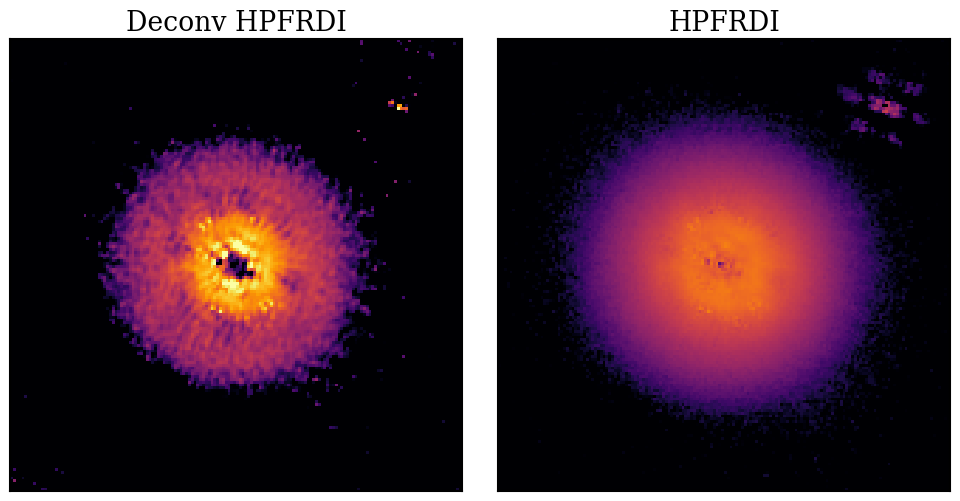

In [14]:
clim = np.array([0.001, 1])*np.nanpercentile(deconv_reduc[0].im, 99.975)
# Visualization and analysis from Task5
fig,axes = quick_implot([deconv_reduc[0].im, deconv_reduc[1].im], extent=deconv_reduc[1].extent, lims=[-5,5], clim=clim, cmap='inferno', norm=mpl.colors.LogNorm,
             interpolation='None', norm_kwargs=dict(clip=True), show=False)

for i,ax in enumerate(axes):
    ax.set_title(deconv_reduc[i].reduc_label.replace(' (Winnie)', ''))